#  DST-Based *BRCA1/2* Risk Estimation

In this notebook, we demonstrate a new method for estimating the likelihood of pathogenic *BRCA1/2* variants using a combined set-based Dempster-Shafer approach.

## Setup

In [1]:
using UncertainEvidence
using IntervalArithmetic
using Interpolations
using DataFrames
using Markdown
using Plots
using PGFPlotsX
using LaTeXStrings

In [2]:
setdisplay(:infsup; decorations = false, ng_flag = false, sigdigits = 4)

Display options:
  - format: infsup
  - decorations: false
  - NG flag: false
  - significant digits: 4

In [3]:
function print_comparison_table(curve_val, prev_val, penn_val, frank_val, boadicea_val)
    if frank_val === nothing
        frank_val = "-"
    end
    
    md"""
    | This approach | Prev. approach | Penn II     | Frank Table  | BOADICEA        |
    |:-------------:|:--------------:|:-----------:|:------------:|:---------------:|
    | $(curve_val)  | $(prev_val)    | $(penn_val) | $(frank_val) | $(boadicea_val) |
    """
end;

In [4]:
generate_f(x, y) = linear_interpolation(reverse(x), reverse(y));

---

## Non-AJ case

### Source data

In [5]:
# age range
age = collect(60:-5:20);

# main risk factors: breast cancer (BC) and ovarian cancer (OC)
BC = [0.04, 0.015, 0.015, 0.02, 0.02, 0.02, 0.03, 0.04, 0.04];
OC = [0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02];

# additional risk factors (constant across all age groups)
bBC = pushfirst!(zeros(length(age)-1), 0.02);       # bilateral BC
mBC = pushfirst!(zeros(length(age)-1), 0.09);       # male BC
sp  = pushfirst!(fill(0.005, length(age)-1), 0.01); # multiple cases in a single person

# thresholds for referral and possible referral
referral = 0.075;
possible_referral = 0.025;

df = DataFrame(
    Age=age,
    BC=cumsum(BC),
    OC=cumsum(OC),
    bBC=cumsum(bBC),
    mBC=cumsum(mBC),
    sp=cumsum(sp)
)

Row,Age,BC,OC,bBC,mBC,sp
,Int64,Float64,Float64,Float64,Float64,Float64
1,60,0.04,0.03,0.02,0.09,0.01
2,55,0.055,0.05,0.02,0.09,0.015
3,50,0.07,0.07,0.02,0.09,0.02
4,45,0.09,0.09,0.02,0.09,0.025
5,40,0.11,0.11,0.02,0.09,0.03
6,35,0.13,0.13,0.02,0.09,0.035
7,30,0.16,0.15,0.02,0.09,0.04
8,25,0.2,0.17,0.02,0.09,0.045
9,20,0.24,0.19,0.02,0.09,0.05


### Risk Modeling

Individual risk curves; cumulative *BRCA1/2* positive rate depending on age of onset.

In [6]:
f_BC  = generate_f(df.Age, df.BC);
f_OC  = generate_f(df.Age, df.OC);
f_bBC = generate_f(df.Age, df.bBC);
f_mBC = generate_f(df.Age, df.mBC);
f_sp  = generate_f(df.Age, df.sp);

# monotonic evaluation
function meval(f, x::Interval)
    fx = (f(inf(x)), f(sup(x)))
    return interval(min(fx...), max(fx...))
end

meval (generic function with 1 method)

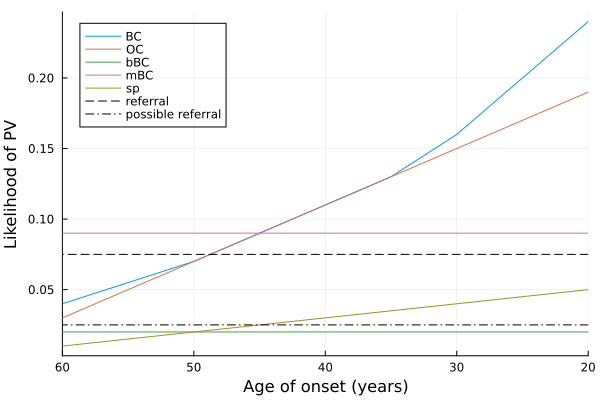

In [7]:
plot(df.Age, f_BC.(df.Age), label="BC", xflip=true, leg=:topleft, xlims=[20,60], xlabel="Age of onset (years)", ylabel="Likelihood of PV", background=:transparent, fmt=:tex)
plot!(df.Age, f_OC.(df.Age), label="OC")
plot!(df.Age, f_bBC.(df.Age), label="bBC")
plot!(df.Age, f_mBC.(df.Age), label="mBC")
plot!(df.Age, f_sp.(df.Age), label="sp")
hline!([referral], label="referral", linestyle=:dash, linecolor="black")
hline!([possible_referral], label="possible referral", linestyle=:dashdot, linecolor="black")

### Mass Assignments

Default case: The proband's age is known exactly.

In [8]:
function m(age::Integer)
    return bpa(
        Set(["BC"])  => f_BC(age),
        Set(["OC"])  => f_OC(age),
        Set(["bBC"]) => f_bBC(age),
        Set(["mBC"]) => f_mBC(age),
        Set(["sp"])  => f_sp(age),
    )
end;

Interval case: If the age of onset (e.g., of a distant relative) is not known exactly, the age parameter can be expressed as an interval.

In [9]:
function m(age::Interval)
    return bpa(
        Set(["BC"])  => meval(f_BC, age),
        Set(["OC"])  => meval(f_OC, age),
        Set(["bBC"]) => meval(f_bBC, age),
        Set(["mBC"]) => meval(f_mBC, age),
        Set(["sp"])  => meval(f_sp, age),
    )
end;

### Examples

#### **Pattern 1:** Father with BC at 42, second degree relative with BC>50

In [10]:
m1 = combine_dempster(m(42), m(interval(51, 60)));
bel1 = bel(["BC", "mBC"], m1);
print_comparison_table(bel1, 0.257, 0.27, nothing, 0.06)

|  This approach   | Prev. approach | Penn II | Frank Table | BOADICEA |
|:----------------:|:--------------:|:-------:|:-----------:|:--------:|
| [0.2518, 0.2934] |     0.257      |  0.27   |      -      |   0.06   |


#### **Pattern 2:** Patient with BC<40 and mother with BC<50

In [11]:
m2 = combine_dempster(m(interval(20, 40)), m(interval(41, 50)))
bel2 = bel(["BC"], m2)
print_comparison_table(bel2, 0.198, "[0.15, 0.35]", 0.297, 0.0521)

|  This approach   | Prev. approach |   Penn II    | Frank Table | BOADICEA |
|:----------------:|:--------------:|:------------:|:-----------:|:--------:|
| [0.1162, 0.3164] |     0.198      | [0.15, 0.35] |    0.297    |  0.0521  |


#### **Pattern 3:** Patient with OC<40 and her aunt BC<50

In [12]:
m3 = m2
bel3 = bel(["BC", "OC"], m3)
print_comparison_table(bel3, 0.358, "[0.12, 0.4]", nothing, 0.0319)

|  This approach   | Prev. approach |   Penn II   | Frank Table | BOADICEA |
|:----------------:|:--------------:|:-----------:|:-----------:|:--------:|
| [0.2325, 0.5836] |     0.358      | [0.12, 0.4] |      -      |  0.0319  |


#### **Pattern 4:** Patient aged 22 with BC and OC; mother has bBC>50

In [13]:
m4 = combine_dempster(m(22), m(interval(51, 60)))
bel4 = bel(["BC", "OC", "sp", "bBC"], m4)
print_comparison_table(bel4, 0.527, 0.54, nothing, 0.3208)

|  This approach   | Prev. approach | Penn II | Frank Table | BOADICEA |
|:----------------:|:--------------:|:-------:|:-----------:|:--------:|
| [0.4461, 0.5483] |     0.527      |  0.54   |      -      |  0.3208  |


---

## AJ case

In [14]:
# different mass assignments for the AJ case
BC_aj  = pushfirst!(zeros(length(age)-1), 0.05);
xBC_aj = pushfirst!(fill(0.00625, length(age)-1), 0.05);
OC_aj  = pushfirst!(zeros(length(age)-1), 0.03);
sp_aj  = pushfirst!(zeros(length(age)-1), 0.01);

df_aj = DataFrame(
    Age=age,
    BC=cumsum(BC+BC_aj),
    OC=cumsum(OC+OC_aj),
    bBC=cumsum(bBC+xBC_aj),
    mBC=cumsum(mBC+xBC_aj),
    sp=cumsum(sp+sp_aj)
)

Row,Age,BC,OC,bBC,mBC,sp
,Int64,Float64,Float64,Float64,Float64,Float64
1,60,0.09,0.06,0.07,0.14,0.02
2,55,0.105,0.08,0.07625,0.14625,0.025
3,50,0.12,0.1,0.0825,0.1525,0.03
4,45,0.14,0.12,0.08875,0.15875,0.035
5,40,0.16,0.14,0.095,0.165,0.04
6,35,0.18,0.16,0.10125,0.17125,0.045
7,30,0.21,0.18,0.1075,0.1775,0.05
8,25,0.25,0.2,0.11375,0.18375,0.055
9,20,0.29,0.22,0.12,0.19,0.06


In [15]:
f_BC_aj  = generate_f(df_aj.Age, df_aj.BC);
f_OC_aj  = generate_f(df_aj.Age, df_aj.OC);
f_bBC_aj = generate_f(df_aj.Age, df_aj.bBC);
f_mBC_aj = generate_f(df_aj.Age, df_aj.mBC);
f_sp_aj  = generate_f(df_aj.Age, df_aj.sp);

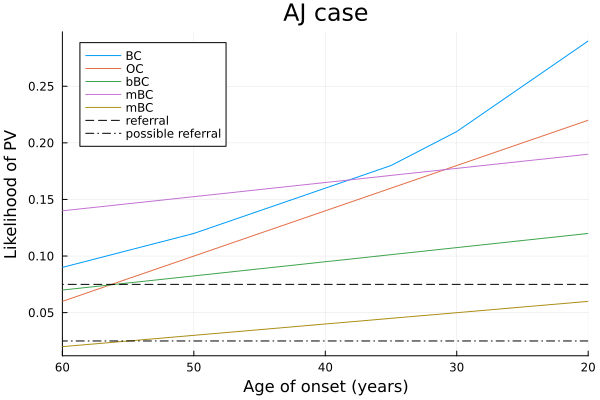

In [16]:
plot(df.Age, f_BC_aj.(df.Age), label="BC", xflip=true, leg=:topleft, plot_title="AJ case", xlims=[20,60], xlabel="Age of onset (years)", ylabel="Likelihood of PV", fmt=:tex)
plot!(df.Age, f_OC_aj.(df.Age), label="OC")
plot!(df.Age, f_bBC_aj.(df.Age), label="bBC")
plot!(df.Age, f_mBC_aj.(df.Age), label="mBC")
plot!(df.Age, f_sp_aj.(df.Age), label="mBC")
hline!([referral], label="referral", linestyle=:dash, linecolor="black")
hline!([possible_referral], label="possible referral", linestyle=:dashdot, linecolor="black")

In [17]:
function m_aj(age::Integer)
    return bpa(
        Set(["BC"])  => f_BC_aj(age),
        Set(["OC"])  => f_OC_aj(age),
        Set(["bBC"]) => f_bBC_aj(age),
        Set(["mBC"]) => f_mBC_aj(age),
        Set(["sp"])  => f_sp_aj(age),
    )
end;

function m_aj(age::Interval)
    return bpa(
        Set(["BC"])  => interval(f_BC_aj(sup(age)),  f_BC_aj(inf(age))),
        Set(["OC"])  => interval(f_OC_aj(sup(age)),  f_OC_aj(inf(age))),
        Set(["bBC"]) => interval(f_bBC_aj(sup(age)), f_bBC_aj(inf(age))),
        Set(["mBC"]) => interval(f_mBC_aj(sup(age)), f_mBC_aj(inf(age))),
        Set(["sp"])  => interval(f_sp_aj(sup(age)),  f_sp_aj(inf(age))),
    )
end;

### Examples

#### **Pattern 1:** Proband (30y-40y) with BC, aunt with BC>51

In [18]:
m1_aj = combine_dempster(m_aj(interval(30, 40)), m_aj(interval(51, 60)));
bel1_aj = bel(["BC"], m1_aj);
print_comparison_table(bel1_aj, 0.319, "[0.24, 0.35]", 0.318, 0.2967)

|  This approach   | Prev. approach |   Penn II    | Frank Table | BOADICEA |
|:----------------:|:--------------:|:------------:|:-----------:|:--------:|
| [0.1493, 0.2743] |     0.319      | [0.24, 0.35] |    0.318    |  0.2967  |


#### **Pattern 2:** Proband with BC at age 45y, sister with OC<50

In [19]:
m2_aj = combine_dempster(m_aj(45), m_aj(interval(41, 50)));
bel2_aj = bel(["BC", "OC"], m2_aj);
print_comparison_table(bel2_aj, 0.313, 0.31, 0.415, 0.6576)

|  This approach   | Prev. approach | Penn II | Frank Table | BOADICEA |
|:----------------:|:--------------:|:-------:|:-----------:|:--------:|
| [0.2962, 0.4051] |     0.313      |  0.31   |    0.415    |  0.6576  |


#### **Pattern 3:** Proband with OC<50 and OC and BC>50 in family history

In [20]:
m3_aj = combine_dempster(m_aj(interval(41, 50)), m_aj(interval(51, 60)));
bel3_aj = bel(["OC", "BC"], m3_aj);
print_comparison_table(bel3_aj, 0.417, 0.41, 0.412, 0.8987)

|  This approach   | Prev. approach | Penn II | Frank Table | BOADICEA |
|:----------------:|:--------------:|:-------:|:-----------:|:--------:|
| [0.2257, 0.4099] |     0.417      |  0.41   |    0.412    |  0.8987  |


#### **Pattern 4:** Proband with OC and BC at 35y, aunt with bBC over 50

In [21]:
m4_aj = combine_dempster(m_aj(35), m_aj(interval(51, 60)));
bel4_aj = bel(["BC", "OC", "sp", "bBC"], m4_aj);
print_comparison_table(bel4_aj, "[0.518,0.656]", 0.53, nothing, 0.9184)

|  This approach   | Prev. approach | Penn II | Frank Table | BOADICEA |
|:----------------:|:--------------:|:-------:|:-----------:|:--------:|
| [0.4598, 0.6029] | [0.518,0.656]  |  0.53   |      -      |  0.9184  |
